# CIFAR100 with Keras

In [1]:
import keras
from keras.layers import  Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.datasets import cifar100

import numpy as np
from matplotlib import pyplot as plt
from collections import namedtuple

Using TensorFlow backend.


In [2]:
(xtrain, ytrain), (xtest, ytest) = cifar100.load_data()

In [3]:
print('Train data:', xtrain.shape, ytrain.shape)
print('Test data:', xtest.shape, ytest.shape)

Train data: (50000, 32, 32, 3) (50000, 1)
Test data: (10000, 32, 32, 3) (10000, 1)


In [5]:
def convert_rbg_to_grayscale(data: np.ndarray) -> np.ndarray:
    return 0.3 * data[:,:,:,0] + 0.59 * data[:,:,:,1] + 0.11 * data[:,:,:,2]


In [6]:
def reshape(data: np.ndarray, shape=None) -> np.ndarray:
    """
    Each image is 1-dimensional array.
    This function reshapes each image to 2-dimensional matrix,
        where its size is defined with `shape`.
        
    Parameters
    ----------
    data: Data that must be reshaped
    shape: Target shape of each image. 
        If not specified, it will reshape to Shape(28, 28)
    
    Returns
    -------
    np.ndarray
    """
    if shape is None:
        shape = Shape(32, 32)
    
    reshaped_data = data.reshape(data.shape[0], shape.rows, shape.columns, 1)
    return reshaped_data

In [7]:
def normalize(data: np.ndarray) -> np.ndarray:
    """
    Normalize data:
        - convert all values in a range within 0 and 1
        - cast all values to float
        
    Parameters
    ----------
    data: Data for training
    
    Returns
    -------
    np.ndarray
    """
    return data.astype('float32') / 255

In [8]:
def encode_into_onehot(y: np.ndarray, number_classes: int):
    """
    Convert an array of answers into onehot encoded matrix.
    
    Parameters
    ----------
    y: target array that will be convert to one hot encoded matrix
    number_classes: total number of classes
    
    Returns
    -------
    np.ndarray, matrix with shape of (number_classes x number_classes)
    """

    if number_classes < 1:
        raise ValueError(f'Number of classes must be greater than 1, given {number_classes}')

    one_hot_encoded_y = keras.utils.to_categorical(y, number_classes)
    return one_hot_encoded_y

In [166]:
def visualize_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Accuracy of the model')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def visualize_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss of the model')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## Current model that is being estimated

In [157]:
# best accuracy 36.53 -- 50 epochs 
Shape = namedtuple('Size', ['rows', 'columns'])

def build_keras_model(window_size: Shape, pool_size: Shape, input_size: tuple, number_classes: int):
    """
    Build keras model based on Sequential
    
    Parameters
    ----------
    window_size: the sliding size of the pixels grid that is convolved. 
    pool_size: Window size which extract features.
    number_classes: Total number of classes that must be distinguished.
    
    Returns
    -------
    Keras model which can be fitted and evaluated.
    """
    model = keras.models.Sequential()
    model.add(Conv2D(32,
                     kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_size))
    model.add(Conv2D(32,
                     kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128,
                     kernel_size=(3, 3), 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128,
                     kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(512, kernel_initializer='lecun_normal', activation='selu', use_bias=True))
    model.add(Dense(512, kernel_initializer='lecun_normal', activation='selu', use_bias=True))
    model.add(Dropout(0.5))
    model.add(Dense(
        units=number_classes,
        activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

In [158]:
converted_xtrain = convert_rbg_to_grayscale(xtrain)
converted_xtest = convert_rbg_to_grayscale(xtest)

In [159]:
reshaped_xtrain = reshape(converted_xtrain, shape=Shape(32, 32))
reshaped_xtest = reshape(converted_xtest, shape=Shape(32, 32))

In [160]:
valid_xtrain = normalize(reshaped_xtrain)
valid_xtest = normalize(reshaped_xtest)

In [161]:
valid_ytrain = encode_into_onehot(ytrain, number_classes=100)
valid_ytest = encode_into_onehot(ytest, number_classes=100)

In [162]:
print('Xtrain shape: ', valid_xtrain.shape)
print('Ytrain shape: ', valid_ytrain.shape)
print('Xtest shape: ', valid_xtest.shape)
print('Ytest shape: ', valid_ytest.shape)

Xtrain shape:  (50000, 32, 32, 1)
Ytrain shape:  (50000, 100)
Xtest shape:  (10000, 32, 32, 1)
Ytest shape:  (10000, 100)


In [163]:
model = build_keras_model(
    window_size=Shape(5, 5),
    pool_size=Shape(2, 2),
    input_size=(32, 32, 1),
    number_classes=100)

## Train

In [164]:
history = model.fit(valid_xtrain, valid_ytrain,
      batch_size=128,
      epochs=50,
      validation_data=(valid_xtest, valid_ytest),
      verbose=1,
)

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 47s 946us/step - loss: 4.5008 - accuracy: 0.0278 - val_loss: 4.2006 - val_accuracy: 0.0752
Epoch 2/50
50000/50000 [==============================] - 49s 982us/step - loss: 4.1098 - accuracy: 0.0815 - val_loss: 3.7425 - val_accuracy: 0.1506
Epoch 3/50
50000/50000 [==============================] - 50s 993us/step - loss: 3.7873 - accuracy: 0.1310 - val_loss: 3.4593 - val_accuracy: 0.1931
Epoch 4/50
50000/50000 [==============================] - 51s 1ms/step - loss: 3.5329 - accuracy: 0.1725 - val_loss: 3.2756 - val_accuracy: 0.2253
Epoch 5/50
50000/50000 [==============================] - 50s 1ms/step - loss: 3.3548 - accuracy: 0.2034 - val_loss: 3.3319 - val_accuracy: 0.2152
Epoch 6/50
50000/50000 [==============================] - 51s 1ms/step - loss: 3.2161 - accuracy: 0.2263 - val_loss: 3.1469 - val_accuracy: 0.2426
Epoch 7/50
50000/50000 [==============================] - 50s 

In [165]:
loss, accuracy = model.evaluate(valid_xtest, valid_ytest, verbose=0)
print('Test loss:', loss * 100)
print('Test accuracy:', accuracy * 100)

Test loss: 219.95008457183837
Test accuracy: 43.220001459121704


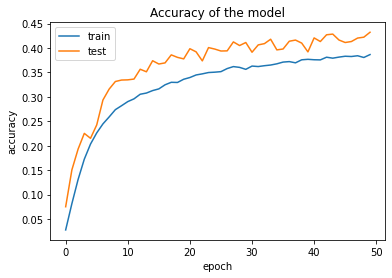

In [167]:
visualize_accuracy(history)

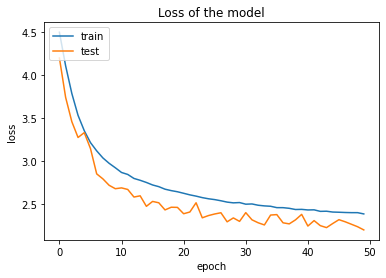

In [168]:
visualize_loss(history)

#  Attempts & scores

## Best accuracy 29.879 % -- 25 epochs

- 3 convolution layers
- 3 max poolings
- 2 dropouts to avoid overfitting
- 2 dense layers
- 1 softmax layer for predictions

In [ ]:
#  best accuracy 29.879 % -- 25 epochs

def build_keras_model(window_size: Shape, pool_size: Shape, input_size: tuple, number_classes: int):
    """
    Build keras model based on Sequential
    
    Parameters
    ----------
    window_size: the sliding size of the pixels grid that is convolved. 
    pool_size: Window size which extract features.
    number_classes: Total number of classes that must be distinguished.
    
    Returns
    -------
    Keras model which can be fitted and evaluated.
    """
    model = keras.models.Sequential()
    model.add(Conv2D(32,
                     kernel_size=tuple(window_size),
                     activation='relu',
                     input_shape=input_size))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, 
                     kernel_size=(3, 3), 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Conv2D(128,
                     kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', use_bias=True))
    model.add(Dense(128, activation='relu', use_bias=True))
    model.add(Dropout(0.5))
    model.add(Dense(
        units=number_classes,
        activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

## Best accuracy 31.52 % -- 35 epochs

- increase number of epochs (25 -> 35)

In [ ]:
# best accuracy 31.520000100135803 -- 35 epochs

def build_keras_model(window_size: Shape, pool_size: Shape, input_size: tuple, number_classes: int):
    """
    Build keras model based on Sequential
    
    Parameters
    ----------
    window_size: the sliding size of the pixels grid that is convolved. 
    pool_size: Window size which extract features.
    number_classes: Total number of classes that must be distinguished.
    
    Returns
    -------
    Keras model which can be fitted and evaluated.
    """
    model = keras.models.Sequential()
    model.add(Conv2D(32,
                     kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_size))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, 
                     kernel_size=(3, 3), 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128,
                     kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', use_bias=True))
    model.add(Dense(128, activation='relu', use_bias=True))
    model.add(Dropout(0.5))
    model.add(Dense(
        units=number_classes,
        activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

## Best accuracy 34.07 % -- 35 epochs

- set dropouts with lesser values to reduce underfitting (0.3 -> 0.25)

In [ ]:
# best accuracy: 34.07 -- 35 epochs

# current attempt: 

def build_keras_model(window_size: Shape, pool_size: Shape, input_size: tuple, number_classes: int):
    """
    Build keras model based on Sequential
    
    Parameters
    ----------
    window_size: the sliding size of the pixels grid that is convolved. 
    pool_size: Window size which extract features.
    number_classes: Total number of classes that must be distinguished.
    
    Returns
    -------
    Keras model which can be fitted and evaluated.
    """
    model = keras.models.Sequential()
    model.add(Conv2D(32,
                     kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_size))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, 
                     kernel_size=(3, 3), 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128,
                     kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', use_bias=True))
    model.add(Dense(128, activation='relu', use_bias=True))
    model.add(Dropout(0.5))
    model.add(Dense(
        units=number_classes,
        activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

## Best accuracy 35.85 % -- 50 epochs

- set dropouts with lesser values to reduce underfitting (0.25 -> 0.2)
- increase number of epochs (35 -> 50)

In [ ]:
# best accuracy - 35.85 - 50 epochs 

def build_keras_model(window_size: Shape, pool_size: Shape, input_size: tuple, number_classes: int):
    """
    Build keras model based on Sequential
    
    Parameters
    ----------
    window_size: the sliding size of the pixels grid that is convolved. 
    pool_size: Window size which extract features.
    number_classes: Total number of classes that must be distinguished.
    
    Returns
    -------
    Keras model which can be fitted and evaluated.
    """
    model = keras.models.Sequential()
    model.add(Conv2D(32,
                     kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_size))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, 
                     kernel_size=(3, 3), 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128,
                     kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', use_bias=True))
    model.add(Dense(128, activation='relu', use_bias=True))
    model.add(Dropout(0.5))
    model.add(Dense(
        units=number_classes,
        activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

## Best accuracy 36.19 % -- 50 epochs

- change optimizer for model (Adadelta -> Adamax)
- add one more dense layer with 92 neurons

In [ ]:
# best accuracy 36.19000017642975 -- 50 epochs 
Shape = namedtuple('Size', ['rows', 'columns'])

def build_keras_model(window_size: Shape, pool_size: Shape, input_size: tuple, number_classes: int):
    """
    Build keras model based on Sequential
    
    Parameters
    ----------
    window_size: the sliding size of the pixels grid that is convolved. 
    pool_size: Window size which extract features.
    number_classes: Total number of classes that must be distinguished.
    
    Returns
    -------
    Keras model which can be fitted and evaluated.
    """
    model = keras.models.Sequential()
    model.add(Conv2D(32,
                     kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_size))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, 
                     kernel_size=(3, 3), 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128,
                     kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', use_bias=True))
    model.add(Dense(128, activation='relu', use_bias=True))
    model.add(Dense(92, activation='relu', use_bias=True))
    model.add(Dropout(0.5))
    model.add(Dense(
        units=number_classes,
        activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adamax(),
                  metrics=['accuracy'])
    return model

## Best accuracy 36.53 % -- 50 epochs

- change optimizer for model (Adamax -> Adam)
- remove dense layer with 92 neurons

In [ ]:
# best accuracy 36.53 -- 50 epochs 
Shape = namedtuple('Size', ['rows', 'columns'])

def build_keras_model(window_size: Shape, pool_size: Shape, input_size: tuple, number_classes: int):
    """
    Build keras model based on Sequential
    
    Parameters
    ----------
    window_size: the sliding size of the pixels grid that is convolved. 
    pool_size: Window size which extract features.
    number_classes: Total number of classes that must be distinguished.
    
    Returns
    -------
    Keras model which can be fitted and evaluated.
    """
    model = keras.models.Sequential()
    model.add(Conv2D(32,
                     kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_size))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, 
                     kernel_size=(3, 3), 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128,
                     kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', use_bias=True))
    model.add(Dense(128, activation='relu', use_bias=True))
    model.add(Dropout(0.5))
    model.add(Dense(
        units=number_classes,
        activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return model

## Best accuracy 41.30 % -- 50 epochs

- add one more convolution layer with 32 units
- add max pooling after the layer
- add dense layer with 128 neurons
- set initial value for layers with lecun normal
- use selu activation

In [ ]:
# best accuracy 41.30 -- 50 epochs 
Shape = namedtuple('Size', ['rows', 'columns'])

def build_keras_model(window_size: Shape, pool_size: Shape, input_size: tuple, number_classes: int):
    """
    Build keras model based on Sequential
    
    Parameters
    ----------
    window_size: the sliding size of the pixels grid that is convolved. 
    pool_size: Window size which extract features.
    number_classes: Total number of classes that must be distinguished.
    
    Returns
    -------
    Keras model which can be fitted and evaluated.
    """
    model = keras.models.Sequential()
    model.add(Conv2D(32,
                     kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_size))
    model.add(Conv2D(32,
                     kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64,
                     kernel_size=(3, 3), 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128,
                     kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(256, kernel_initializer='lecun_normal', activation='selu', use_bias=True))
    model.add(Dense(128, kernel_initializer='lecun_normal', activation='selu', use_bias=True))
    model.add(Dense(128, kernel_initializer='lecun_normal', activation='selu', use_bias=True))
    model.add(Dropout(0.5))
    model.add(Dense(
        units=number_classes,
        activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adamax(),
                  metrics=['accuracy'])
    return model

## Best accuracy 42.34 % -- 50 epochs

- remove one dense layer with 128 neurons

In [ ]:
# best accuracy 42.34 -- 50 epochs 
Shape = namedtuple('Size', ['rows', 'columns'])

def build_keras_model(window_size: Shape, pool_size: Shape, input_size: tuple, number_classes: int):
    """
    Build keras model based on Sequential
    
    Parameters
    ----------
    window_size: the sliding size of the pixels grid that is convolved. 
    pool_size: Window size which extract features.
    number_classes: Total number of classes that must be distinguished.
    
    Returns
    -------
    Keras model which can be fitted and evaluated.
    """
    model = keras.models.Sequential()
    model.add(Conv2D(32,
                     kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_size))
    model.add(Conv2D(32,
                     kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64,
                     kernel_size=(3, 3), 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128,
                     kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(256, kernel_initializer='lecun_normal', activation='selu', use_bias=True))
    model.add(Dense(128, kernel_initializer='lecun_normal', activation='selu', use_bias=True))
    model.add(Dropout(0.5))
    model.add(Dense(
        units=number_classes,
        activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adamax(),
                  metrics=['accuracy'])
    return model

## Best accuracy 42.63 % -- 50 epochs

- increase number of the first dense layer unit (256 -> 512)

In [ ]:
# best accuracy 42.63 -- 50 epochs 
Shape = namedtuple('Size', ['rows', 'columns'])

def build_keras_model(window_size: Shape, pool_size: Shape, input_size: tuple, number_classes: int):
    """
    Build keras model based on Sequential
    
    Parameters
    ----------
    window_size: the sliding size of the pixels grid that is convolved. 
    pool_size: Window size which extract features.
    number_classes: Total number of classes that must be distinguished.
    
    Returns
    -------
    Keras model which can be fitted and evaluated.
    """
    model = keras.models.Sequential()
    model.add(Conv2D(32,
                     kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_size))
    model.add(Conv2D(32,
                     kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64,
                     kernel_size=(3, 3), 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128,
                     kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(512, kernel_initializer='lecun_normal', activation='selu', use_bias=True))
    model.add(Dense(256, kernel_initializer='lecun_normal', activation='selu', use_bias=True))
    model.add(Dropout(0.5))
    model.add(Dense(
        units=number_classes,
        activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adamax(),
                  metrics=['accuracy'])
    return model

## Best accuracy 43.22 % -- 50 epochs

- swap convolution layer with 64 units -> 128 units
- swap dense layer with 256 neurons -> 512 neurons
- change optimizer for model (Adamax -> Adadelta)

In [ ]:
# best accuracy 43.22 -- 50 epochs 
Shape = namedtuple('Size', ['rows', 'columns'])

def build_keras_model(window_size: Shape, pool_size: Shape, input_size: tuple, number_classes: int):
    """
    Build keras model based on Sequential
    
    Parameters
    ----------
    window_size: the sliding size of the pixels grid that is convolved. 
    pool_size: Window size which extract features.
    number_classes: Total number of classes that must be distinguished.
    
    Returns
    -------
    Keras model which can be fitted and evaluated.
    """
    model = keras.models.Sequential()
    model.add(Conv2D(32,
                     kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_size))
    model.add(Conv2D(32,
                     kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128,
                     kernel_size=(3, 3), 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128,
                     kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(512, kernel_initializer='lecun_normal', activation='selu', use_bias=True))
    model.add(Dense(512, kernel_initializer='lecun_normal', activation='selu', use_bias=True))
    model.add(Dropout(0.5))
    model.add(Dense(
        units=number_classes,
        activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model